In [ ]:
import tensorflow as tf
#This import was used to count my specific labels
from collections import Counter

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

**Imports for image reading**

In [ ]:
import PIL
from PIL import Image
from matplotlib import image
print('Pillow Version:', PIL.__version__)

Pillow Version: 7.0.0


Imports for modeling:

In [ ]:

from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, roc_auc_score, confusion_matrix, multilabel_confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers 
from tensorflow.keras import Model 
from keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
#Periodically ran this cell to see if it would help with memory constraints when using Jupyter Notebooks. Keeping here to remind me
#of the resource!
import gc

In [ ]:
gc.collect()

0

In [ ]:
#The following modules allow me to mount Google drive to colab (where my image files were stored for this project)
from google.colab import drive

In [ ]:
#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
%matplotlib inline

## Target Data (and associated EDA features
---

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/My\ Drive/'Colab Notebooks/data'

Data_Entry_2017_v2020.csv


In [ ]:
path = '/content/gdrive/MyDrive/Colab Notebooks/data/Data_Entry_2017_v2020.csv'

In [ ]:
df = pd.read_csv(path)

In [ ]:
df.columns = df.columns.map({col:col.lower().replace(' ','_') for col in df.columns})

In [ ]:
df.head()

,image_index,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,originalimage[width,height],originalimagepixelspacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [ ]:
df.shape

(112120, 11)

In [ ]:
df.finding_labels.nunique()

836

In [ ]:
df.finding_labels.unique()[:20]

array(['Cardiomegaly', 'Cardiomegaly|Emphysema', 'Cardiomegaly|Effusion',
       'No Finding', 'Hernia', 'Hernia|Infiltration', 'Mass|Nodule',
       'Infiltration', 'Effusion|Infiltration', 'Nodule', 'Emphysema',
       'Effusion', 'Atelectasis', 'Effusion|Mass', 'Infiltration|Mass',
       'Infiltration|Mass|Pneumothorax', 'Mass',
       'Cardiomegaly|Infiltration|Mass|Nodule',
       'Cardiomegaly|Effusion|Emphysema|Mass',
       'Atelectasis|Cardiomegaly|Emphysema|Mass|Pneumothorax'],
      dtype=object)

In [ ]:
df.finding_labels.value_counts(normalize = True)[:20]

No Finding                           0.538361
Infiltration                         0.085150
Atelectasis                          0.037594
Effusion                             0.035275
Nodule                               0.024126
Pneumothorax                         0.019568
Mass                                 0.019078
Effusion|Infiltration                0.014297
Atelectasis|Infiltration             0.012041
Consolidation                        0.011684
Atelectasis|Effusion                 0.010391
Pleural_Thickening                   0.010043
Cardiomegaly                         0.009748
Emphysema                            0.007956
Infiltration|Nodule                  0.007394
Atelectasis|Effusion|Infiltration    0.006573
Fibrosis                             0.006484
Edema                                0.005601
Cardiomegaly|Effusion                0.004317
Consolidation|Infiltration           0.003933
Name: finding_labels, dtype: float64

In [ ]:
df.isnull().sum()

image_index                    0
finding_labels                 0
follow-up_#                    0
patient_id                     0
patient_age                    0
patient_gender                 0
view_position                  0
originalimage[width            0
height]                        0
originalimagepixelspacing[x    0
y]                             0
dtype: int64

In [ ]:
df.finding_labels[50:55]

50                 Emphysema|Pneumothorax
51               Atelectasis|Pneumothorax
52                           Pneumothorax
53    Cardiomegaly|Emphysema|Pneumothorax
54                             No Finding
Name: finding_labels, dtype: object

In [ ]:
labels = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 
          'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'No Finding']

In [ ]:
#Trying to reduce the number of unique instances
def alphabetize(string):
    labels = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 
          'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'No Finding']
    grouping = [finding for finding in labels if finding in string]
    grouping = []
    for i in labels:
        if i in string:
            grouping.append(i)
    return grouping

In [ ]:
tuple(df.finding_labels[50].split('|'))

('Emphysema', 'Pneumothorax')

In [ ]:
df.finding_labels[12]

'Mass|Nodule'

In [ ]:
alphabetize(df.finding_labels[12])

['Mass', 'Nodule']

In [ ]:
alphabetize('Nodule|Mass')

['Mass', 'Nodule']

In [ ]:
alphabetize(df.finding_labels[0])

['Cardiomegaly']

In [ ]:
df.finding_labels[112092]

'Cardiomegaly|Effusion|Emphysema|Pneumothorax'

In [ ]:
alphabetize(df.finding_labels[112092])

['Cardiomegaly', 'Effusion', 'Pneumothorax', 'Emphysema']

In [ ]:
df['finding_labels_clean'] = df.finding_labels.apply(alphabetize)

In [ ]:
df.finding_labels.nunique()

836

Method for building generator and this count are from [this site](https://godatadriven.com/blog/keras-multi-label-classification-with-imagedatagenerator/)

In [ ]:
#Providing accurate counts for each individual label
labels_count = Counter(label for lbs in df['finding_labels_clean'] for label in lbs)

In [ ]:
labels_count #112120 total images, but this should sum to more than that as more than 1 label may appear on a given image

Counter({'Atelectasis': 11559,
         'Cardiomegaly': 2776,
         'Consolidation': 4667,
         'Edema': 2303,
         'Effusion': 13317,
         'Emphysema': 2516,
         'Fibrosis': 1686,
         'Hernia': 227,
         'Infiltration': 19894,
         'Mass': 5782,
         'No Finding': 60361,
         'Nodule': 6331,
         'Pleural_Thickening': 3385,
         'Pneumonia': 1431,
         'Pneumothorax': 5302})

In [ ]:
total_count = sum(labels_count.values())
class_weights = {cls: total_count / count for cls, count in labels_count.items()}

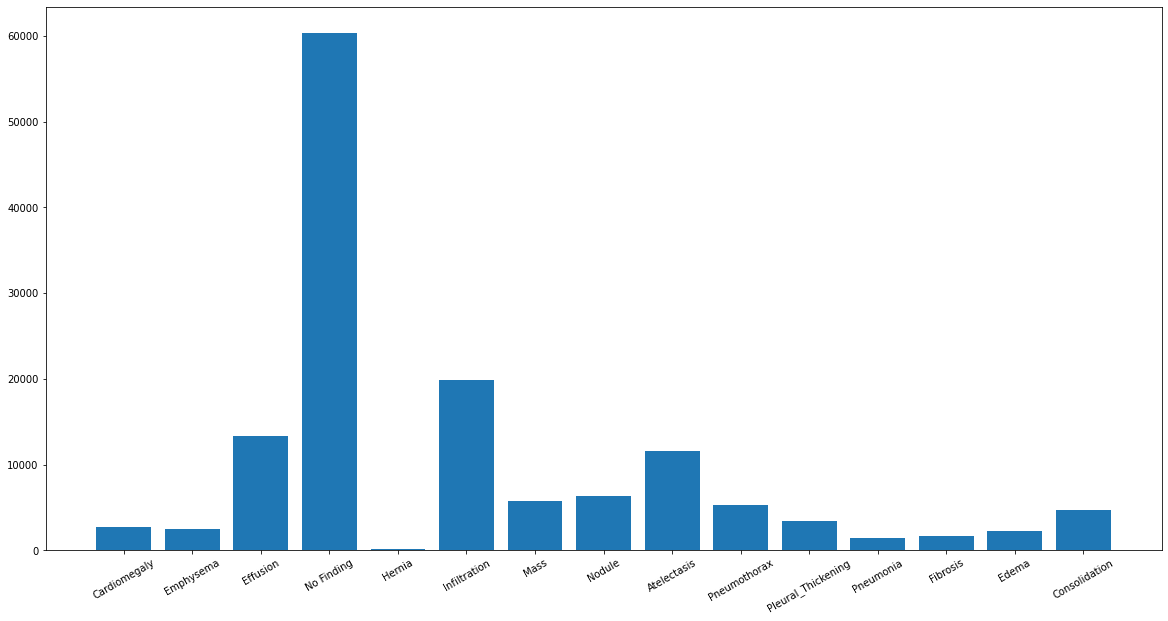

In [ ]:
plt.figure(figsize = (20, 10))
plt.bar(labels_count.keys(),labels_count.values())
plt.xticks(rotation = 30)
plt.xlabel('Clinical Findings', fontsize = 12)
plt.ylabel('Number of findings', fontsize = 12)
plt.title('Total Number of Each Finding in the Data', fontsize = 15);

In [ ]:
df.finding_labels_clean[112092]

['Cardiomegaly', 'Effusion', 'Pneumothorax', 'Emphysema']

In [ ]:

df.finding_labels_clean.value_counts()[-7:].index

Index([                           ['Atelectasis', 'Mass', 'Nodule', 'Pneumonia'],
                                             ['Mass', 'Consolidation', 'Hernia'],
                   ['Atelectasis', 'Infiltration', 'Mass', 'Nodule', 'Fibrosis'],
                        ['Atelectasis', 'Infiltration', 'Emphysema', 'Fibrosis'],
                               ['Effusion', 'Infiltration', 'Mass', 'Emphysema'],
                                     ['Infiltration', 'Mass', 'Nodule', 'Edema'],
       ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Mass', 'Pleural_Thickening']],
      dtype='object')

In [ ]:
df.finding_labels_clean.values.tolist()[:10]

[['Cardiomegaly'],
 ['Cardiomegaly', 'Emphysema'],
 ['Cardiomegaly', 'Effusion'],
 ['No Finding'],
 ['Hernia'],
 ['Hernia'],
 ['Infiltration', 'Hernia'],
 ['Hernia'],
 ['Hernia'],
 ['Hernia']]

In [ ]:
df.shape

(112120, 12)

In [ ]:
not_labels = [i for i in df.columns[2:] if i not in labels]
not_labels

['follow-up_#',
 'patient_id',
 'patient_age',
 'patient_gender',
 'view_position',
 'originalimage[width',
 'height]',
 'originalimagepixelspacing[x',
 'y]',
 'finding_labels_clean']

## Image data (Modelling Features)
---

## DEBUG
----

In [ ]:
#It appears that these images are not in the correct order. This is going to cause some random subset to be missing the values.
#Much worse, it's going to make my array images completely out of order. This is bad
df[df.image_index == '00000003_000.png']

,image_index,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,originalimage[width,height],originalimagepixelspacing[x,y],finding_labels_clean
11,00000003_000.png,Hernia,7,3,81,F,PA,2582,2991,0.143,0.143,[Hernia]


In [ ]:
int(df.image_index[0].split('_')[0])

1

In [ ]:
df.image_index[0].split('_')[1].split('.')[0]

'000'

In [ ]:
df[['image_index', 'patient_id', 'follow-up_#']] #They already have this together. I will need to sort by these to 
#get the image indices back together

,image_index,patient_id,follow-up_#
0,00000001_000.png,1,0
1,00000001_001.png,1,1
2,00000001_002.png,1,2
3,00000002_000.png,2,0
4,00000003_001.png,3,0
...,...,...,...
112115,00030801_001.png,30801,1
112116,00030802_000.png,30802,0
112117,00030803_000.png,30803,0
112118,00030804_000.png,30804,0


In [ ]:
arranger = df.sort_values(by = ['patient_id', 'follow-up_#'])

In [ ]:
arranger.head(12)

,image_index,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,originalimage[width,height],originalimagepixelspacing[x,y],finding_labels_clean
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143,[Cardiomegaly]
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,"[Cardiomegaly, Emphysema]"
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,"[Cardiomegaly, Effusion]"
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171,[No Finding]
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168,[Hernia]
5,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,0.168,[Hernia]
6,00000003_003.png,Hernia|Infiltration,2,3,76,F,PA,2698,2991,0.143,0.143,"[Infiltration, Hernia]"
7,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,0.168,[Hernia]
8,00000003_005.png,Hernia,4,3,78,F,PA,2686,2991,0.143,0.143,[Hernia]
9,00000003_006.png,Hernia,5,3,79,F,PA,2992,2991,0.143,0.143,[Hernia]


This is still not fixing the issue. Sadly, the patient number and follow up numbers are not correctly matching the image naming protocols. This is why my images and theirs are out of order. So, I WILL have to manually restructure this to match the image filing system. Hooray...

In [ ]:
#making a file patient num and file image num column, then sorting
print(int(df.image_index[0].split('_')[0]))
df['fpt_num'] = df.image_index.apply(lambda x: int(x.split('_')[0]))
df['fimg_num'] = df.image_index.apply(lambda x: int(x.split('_')[1].split('.')[0]))

1


In [ ]:
df[['image_index', 'fpt_num', 'fimg_num']].head(12)
#This appears to be set to create the correct sort

,image_index,fpt_num,fimg_num
0,00000001_000.png,1,0
1,00000001_001.png,1,1
2,00000001_002.png,1,2
3,00000002_000.png,2,0
4,00000003_001.png,3,1
5,00000003_002.png,3,2
6,00000003_003.png,3,3
7,00000003_004.png,3,4
8,00000003_005.png,3,5
9,00000003_006.png,3,6


In [ ]:
arranger = df.sort_values(by = ['fpt_num', 'fimg_num']).reset_index()

In [ ]:
df = arranger.drop(columns = 'index')
df.drop(columns = ['fpt_num', 'fimg_num'], inplace = True)

In [ ]:
df.head(12)

,image_index,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,originalimage[width,height],originalimagepixelspacing[x,y],finding_labels_clean
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143,[Cardiomegaly]
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,"[Cardiomegaly, Emphysema]"
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,"[Cardiomegaly, Effusion]"
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171,[No Finding]
4,00000003_000.png,Hernia,7,3,81,F,PA,2582,2991,0.143,0.143,[Hernia]
5,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168,[Hernia]
6,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,0.168,[Hernia]
7,00000003_003.png,Hernia|Infiltration,2,3,76,F,PA,2698,2991,0.143,0.143,"[Infiltration, Hernia]"
8,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,0.168,[Hernia]
9,00000003_005.png,Hernia,4,3,78,F,PA,2686,2991,0.143,0.143,[Hernia]


It appears that the original indices phased in and out with this new index. That's why my x ray image in my array and my sub list were only off by a few images.

## Getting the Subset Data from the DF
---

In [ ]:
#I created a test subset of groupings from each folder of data to begin models. The following code is how I achieved this.

# #A list of start and end + 1 indices of the subset of images (slicing will not be inclusive)
# indices = [[0, 407], [4999, 5366], [14999, 15492], [24999, 25791], [34999, 35353],
#           [44999, 45516], [54999, 55376], [64999, 65502], [74999, 75335], [84999, 85444],
#           [94999, 95116], [104999, 105280]]

In [ ]:
# #Confirming that these match the first and last entries in my subset folders
# for i in indices:
#     print(df.loc[i[0]].image_index, df.loc[i[1] - 1].image_index)

In [ ]:
# list_dfs = []
# for ind in indices:
#     list_dfs.append(df.iloc[ind[0]:ind[1]])

In [ ]:
# df_sub = pd.concat(list_dfs)

In [ ]:
#When modeling the entire data, I needed to create a full path to each file, but the were spread across 12 folders. I had moved several
#images prior to doing this manually, but then created this function to create a full path for each file, so the Keras
#ImageDataGenerator can find every image.

def path_setup():
    path = '/content/gdrive/MyDrive/Capstone_Images/'
    all_dfs = []
    midpath = ['images/', 'images_5/', 'images_6/', 'images_7/', 'images_8/', 
               'images_9/','images_10/','images_11/', 'images_12/']
    
    low = ['000000001_000.png', '00010927_001.png','00011558_008.png','00013774_026.png','00016051_010.png',
          '00018387_035.png', '00020945_050.png','00024718_000.png','00028173_003.png']
    high = ['00010927_001.png','00011558_008.png','00013774_026.png','00016051_010.png','00018387_035.png',
           '00020945_050.png','00024718_000.png','00028173_003.png','00030805_000.png']
    
    for i,j,k in zip(low, high, midpath):
        if i == '000000001_000.png':
            df_sub = df.iloc[: df[df.image_index == j].index.values[0]]
            df_sub['path'] = df_sub.image_index.apply(lambda x: path + k + x)
            all_dfs.append(df_sub)
            
        elif j == '00030805_000.png':
            df_sub = df.iloc[df[df.image_index == i].index.values[0]:]
            df_sub['path'] = df_sub.image_index.apply(lambda x: path + k + x)
            all_dfs.append(df_sub)
            
        else:
            df_sub = df.iloc[df[df.image_index == i].index.values[0]: df[df.image_index == j].index.values[0]]
            df_sub['path'] = df_sub.image_index.apply(lambda x: path + k + x)
            all_dfs.append(df_sub)
    
    new_df = pd.concat(all_dfs)
    print(len(all_dfs) == 9)
    return new_df

In [ ]:
df_sub = path_setup()

True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [ ]:
#I have verified that each subset of image indices matches what is in my folders
df_sub.tail()

,image_index,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,originalimage[width,height],originalimagepixelspacing[x,y],finding_labels_clean,path
112115,00030801_001.png,Mass|Pneumonia,1,30801,38,M,PA,2048,2500,0.168,0.168,"[Mass, Pneumonia]",/content/gdrive/MyDrive/Capstone_Images/images...
112116,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,0.168,[No Finding],/content/gdrive/MyDrive/Capstone_Images/images...
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,[No Finding],/content/gdrive/MyDrive/Capstone_Images/images...
112118,00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,0.168,[No Finding],/content/gdrive/MyDrive/Capstone_Images/images...
112119,00030805_000.png,No Finding,0,30805,26,M,PA,2048,2500,0.171,0.171,[No Finding],/content/gdrive/MyDrive/Capstone_Images/images...


EXCELLENT! Now I can model

## Model of Subset Data
---

The goal here, as from [this article](https://medium.com/@ckyeungac/a-simple-trick-about-multi-label-image-classification-with-imagedatagenerator-in-keras-4ab95364a481), is to find a way to one hot encode my labels and keep them. The stroke of genius is to pass the indices as y column in flow, then go back and retrieve the labels.

In [ ]:
print(labels)

['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'No Finding']


In [ ]:
df_flow = df_sub[['path', 'finding_labels_clean']].reset_index()
df_flow['index'] = df_flow.index
#Comment below out if planning to run all data: this was merely to make visualizations
df_flow = df_flow.sample(frac = 0.2)

In [ ]:
df_flow.head()

,index,path,finding_labels_clean
0,0,/content/gdrive/MyDrive/Capstone_Images/images...,[Cardiomegaly]
1,1,/content/gdrive/MyDrive/Capstone_Images/images...,"[Cardiomegaly, Emphysema]"
2,2,/content/gdrive/MyDrive/Capstone_Images/images...,"[Cardiomegaly, Effusion]"
3,3,/content/gdrive/MyDrive/Capstone_Images/images...,[No Finding]
4,4,/content/gdrive/MyDrive/Capstone_Images/images...,[Hernia]


In [ ]:
df_flow.head()

,index,path,finding_labels_clean
0,0,/content/gdrive/MyDrive/Capstone_Images/images...,[Cardiomegaly]
1,1,/content/gdrive/MyDrive/Capstone_Images/images...,"[Cardiomegaly, Emphysema]"
2,2,/content/gdrive/MyDrive/Capstone_Images/images...,"[Cardiomegaly, Effusion]"
3,3,/content/gdrive/MyDrive/Capstone_Images/images...,[No Finding]
4,4,/content/gdrive/MyDrive/Capstone_Images/images...,[Hernia]


In [ ]:
fullpath = '/content/gdrive/MyDrive/Capstone_Images/images'

In [ ]:
#path = '/content/gdrive/MyDrive/Capstone_Images/test_dir'
datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2, horizontal_flip = True, vertical_flip = True)

In [ ]:
training = datagen.flow_from_dataframe(dataframe = df_flow, directory = None,
                                   x_col = 'path', y_col = 'finding_labels_clean',
                                    class_mode = 'categorical', seed = 42,
                                    subset = 'training',
                                   batch_size = 24, target_size = (224, 224),#build back to this goal -->(1024, 1024),
                                   color_mode = 'rgb')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 4201 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 86336 validated image filenames belonging to 15 classes.


In [ ]:
test = datagen.flow_from_dataframe(dataframe = df_flow, directory = None,
                                   x_col = 'path', y_col = 'finding_labels_clean',
                                    class_mode = 'categorical', seed = 42,
                                    subset = 'validation',
                                   batch_size = 24, target_size = (224, 224),#(1024, 1024),
                                   color_mode = 'rgb')

Found 21586 validated image filenames belonging to 15 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 4190 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
training.n, test.n

(86336, 21586)

In [ ]:
df_flow

,index,path,finding_labels_clean
0,0,/content/gdrive/MyDrive/Capstone_Images/images...,[Cardiomegaly]
1,1,/content/gdrive/MyDrive/Capstone_Images/images...,"[Cardiomegaly, Emphysema]"
2,2,/content/gdrive/MyDrive/Capstone_Images/images...,"[Cardiomegaly, Effusion]"
3,3,/content/gdrive/MyDrive/Capstone_Images/images...,[No Finding]
4,4,/content/gdrive/MyDrive/Capstone_Images/images...,[Hernia]
...,...,...,...
112115,112115,/content/gdrive/MyDrive/Capstone_Images/images...,"[Mass, Pneumonia]"
112116,112116,/content/gdrive/MyDrive/Capstone_Images/images...,[No Finding]
112117,112117,/content/gdrive/MyDrive/Capstone_Images/images...,[No Finding]
112118,112118,/content/gdrive/MyDrive/Capstone_Images/images...,[No Finding]


In [ ]:
final_labels = labels
final_labels

['Atelectasis',
 'Cardiomegaly',
 'Effusion',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pneumonia',
 'Pneumothorax',
 'Consolidation',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Pleural_Thickening',
 'Hernia',
 'No Finding']

In [ ]:
#Before using the ImageDataGenerator, this is how I extracted my original classes from predictions of 15 0s and 1s

def make_preds(arr):
    final_list = []
    for pred in range(len(arr)):
        dictest = {val:arr[pred][ind] for ind,val in enumerate(final_labels)}
        ret_list = [i for i in dictest.keys() if dictest[i] != 0]
        final_list.append(ret_list)
    return final_list

In [ ]:
#The neural network needs to know what the step size will be since the batches are defined in the generator above
step_train=training.n//training.batch_size
step_test=test.n//test.batch_size

In [ ]:
#Base imported from keras, added to custom made top layers
base_model = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    classes = 15,
    pooling = 'avg',
    input_shape=(224, 224, 3)
)

29089792/29084464 [==============================] - 1s 0us/step


In [ ]:
#Base model output goes into x, then concatenate them all into one overaching model
x=base_model.output
x=Flatten()(x)

#Top layers after flattening base model output
x=Dense(25000,activation='relu')(x)
#x=Dense(15024,activation='relu')(x)
x=Dense(10024,activation='relu')(x)
x=Dense(10024,activation='relu')(x)
x=Dense(5024,activation='relu')(x)
x=Dense(2024,activation='relu')(x) #we add dense layers so that the model can learn more complex 
#functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(712,activation='relu')(x) #dense layer 3

# Add a final sigmoid layer for classification for multi label problems
x = layers.Dense(15, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

In [ ]:
#Commenting out but keeping this scaffold - first attempted CNN build model, prior to importing Keras models

# model = Sequential()

# model.add(Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = (224, 224, 1)))


# model.add(Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2, 2)))

# model.add(Conv2D(64, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2, 2)))

# #model.add(Conv2D(64, kernel_size = (3, 3), padding = 'same', activation = 'relu'))

# #model.add(Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
# #model.add(MaxPool2D(pool_size = (2, 2)))

# #kernel_regularizer = l2(0.02)

# model.add(GlobalAveragePooling2D())

# model.add(Dense(10_000, activation = 'relu'))
# model.add(Dense(5000, activation = 'relu'))
# model.add(Dense(2500, activation = 'relu'))
# model.add(Dense(1200, activation = 'relu'))
# model.add(Dense(800, activation = 'relu'))
# model.add(Dense(600, activation = 'relu'))

# model.add(Dense(400, activation = 'relu'))

# #model.add(Dense(100, activation = 'relu'))

# model.add(Dense(15, activation = 'sigmoid'))

In [ ]:
opt = Adam(lr=0.001) #Defined here in case I wish to increase/decrease learning rate (if the gradient steps are too low/high)

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [ ]:
model.summary() #The result of base + top concatenated model

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
#Toying with increasing batch size to max useable rather than decreasing learning rate

epoch = 10
cnn_path = '/content/gdrive/MyDrive/cnn_weights/multilabel_train/'

#save the model weights in case they improve
model_checkpoint_callback = ModelCheckpoint(
    filepath = cnn_path,
    save_weights_only=True,
    monitor='loss',#'val_loss',
    mode='min',
    save_freq = 500, #'epoch',
    save_best_only=True, verbose = 1)

In [ ]:
model.load_weights(cnn_path) #--> will load in the model weights after you have made some

history = model.fit(training, steps_per_epoch = step_train, 
                    validation_data = test, 
                     validation_steps= step_test, epochs = epoch, callbacks = model_checkpoint_callback)

Epoch 1/10
 499/3597 [===>..........................] - ETA: 9:30:33 - loss: 0.2220 - accuracy: 0.5219
Epoch 00001: loss improved from inf to 0.22198, saving model to /content/gdrive/MyDrive/cnn_weights/multilabel_train/
 999/3597 [=======>......................] - ETA: 7:58:47 - loss: 0.2208 - accuracy: 0.5275
Epoch 00001: loss improved from 0.22198 to 0.22093, saving model to /content/gdrive/MyDrive/cnn_weights/multilabel_train/
1499/3597 [===========>..................] - ETA: 6:27:50 - loss: 0.2203 - accuracy: 0.5282
Epoch 00001: loss improved from 0.22093 to 0.22036, saving model to /content/gdrive/MyDrive/cnn_weights/multilabel_train/
1999/3597 [===============>..............] - ETA: 4:55:33 - loss: 0.2212 - accuracy: 0.5261
Epoch 00001: loss did not improve from 0.22036
2499/3597 [===================>..........] - ETA: 3:23:43 - loss: 0.2207 - accuracy: 0.5279
Epoch 00001: loss did not improve from 0.22036
2999/3597 [========================>.....] - ETA: 1:51:56 - loss: 0.2208 

In [ ]:
# I suspect that this model is failing to improve because I lack the computing power to pass a significant enough batch size to
#allow it to converge. There are also far too many and too imbalanced of classes. I will optimize this in later use of this project

In [ ]:
model.save('/content/gdrive/MyDrive/saved_models/multilabel')

## Model Performance
---

VGG 16
- imagenet weights (coded rbg)
- 3 dense layers (412, 412, 250)
- 10 epochs: final train acc: 58.79% || test acc: 55.52%
- final train loss: .1988 || test loss: .2131

**VGG-16 (Fully Trained)**
- failed to pick up on signal after 10 epochs

**Xception**


In [ ]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize = (12, 10))

plt.plot(train_loss, color = 'skyblue', label = 'Training Loss')
plt.plot(test_loss, color = 'orange', label = 'Testing Loss')

plt.title('Multi-label Loss scores of Train and Test by Epoch - DenseNet121', fontsize = 16)
plt.xlabel('Epoch Number', fontsize = 12)
plt.ylabel('Binary Crossentropy', fontsize = 12)
plt.xticks(np.arange(epoch), np.arange(epoch))

plt.legend();

In [ ]:
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

plt.figure(figsize = (12, 10))

plt.plot(train_acc, color = 'green', label = 'Training Accuracy')
plt.plot(test_acc, color = 'blue', label = 'Testing Accuracy')

plt.title('Multi-label Accuracy scores of Train and Test by Epoch - DenseNet121', fontsize = 16)
plt.xlabel('Epoch Number', fontsize = 12)
plt.ylabel('Binary Crossentropy', fontsize = 12)
plt.xticks(np.arange(epoch), np.arange(epoch))

plt.legend();

In [ ]:

#testitpred = model.predict(training)

In [ ]:
pred_classes = (model.predict(training) > 0.5).astype("int32")

In [ ]:
final_labels = [i for i in training.class_indices.keys()]

In [ ]:
pred_classes[:5]

In [ ]:
training_predictions = make_preds(pred_classes)

In [ ]:
test_preds = (model.predict(test) > 0.5).astype("int32")

In [ ]:
test_predictions = make_preds(test_preds)

In [ ]:
test_preds[:5]

In [ ]:
training.class_indices

In [ ]:
training.index_array

In [ ]:
df_eval = df_flow.iloc[training.index_array]

In [ ]:
df_eval['model_predictions'] = training_predictions

In [ ]:
df_eval.head(30)

In [ ]:
df_eval_test = df_flow.iloc[test.index_array]

In [ ]:
df_eval_test['model_predictions'] = test_predictions

In [ ]:
df_eval_test.head(30)

This model *technically* predicts multiple classes, however, at the moment it is predicting the majority class only. Review this as you consider methods of collapsing correlated labels.